# Experimental Analysis: Confinement Regimes

| Parameters | signals | units |
|------------|---------|-------|
| Plasma current	| 	`sipmes`	| 	MA |
| Electron temperature	| 	`gshte`	| 	keV |
| Line integrated electron density	| 	`gnl`	| 	m-2	| 
| Magnetic field		| `rbtor`		| T	| 
| ICRH /  LHCD power	| 	`gpuifci%4` /  `gphyb%3`	| 	MW	| 
| Ohmic power		| `spohm`		| MW	| 
| Diamagnetic energy		| `swdia`	| 	MJ	| 
| Plasma elongation		| `sellip`		| 
| Minor/Major radius		| `saeqa` /  `srmaj`		| m	| 


| Shot number |	B toroidal (T)	| Duration (s) |
|-------------|-----------------|--------------|
| #40999	| 3.18	| 5.7| 
| #41003	| 3.87	| 13.0| 
| #41004	| 3.87	| 13.0| 
| #41005	| 3.87	| 14.5| 
| #41006	| 3.87	| 13.1| 
| #41007	| 3.87	| 13.0| 
| #41008	| 3.87	| 13.0| 
| #41009	| 3.87	| 13.0| 
| #41010	| 3.87	| 13.0| 
| #41011	| 3.87	| 12.9| 
| #41012	| 3.87	| 12.9| 
| #41013	| 3.87	| 13.1| 


Below we retrieve the data locally, in order to be able to work without the intranet access.

In [115]:
%matplotlib notebook
import pywed as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.interpolate import interp1d
from scipy.integrate import trapz

from scipy.constants import pi, e, Boltzmann as k_B

In [84]:
# Pulses and signal lists
pulses = [40999, 41003, 41004, 41005, 41006, 41007, 
          41008, 41009, 41010, 41011, 41012, 41013]
signals = ['sipmes', 'gnl', 'rbtor', 'gpuifci%4', 'gphyb%3', 
           'spohm', 'sellip', 'saeqa', 'srmaj', 'gne', 
           'swdia', 'staudia', 'gshte', 'gshr']

In [95]:
# retrieve all the data locally
# The for loop i
if Path('Tore_Supra.npz').exists():
    data = np.load('Tore_Supra.npz')['arr_0'].all()
else:
    data = {}
    for pulse in pulses:
        data[pulse] = {}
        for signal in signals:
            try:
                print(pulse)
                alldata = pd.tsbase(pulse, signal) 
                data[pulse][signal] = alldata
            except PyWEDException as e: # if signal does not exist, then not big deal
                pass
    np.savez('Tore_Supra', data) 

In [96]:
db=data

## Which plasma discharges are not suitable ?

<IPython.core.display.Javascript object>


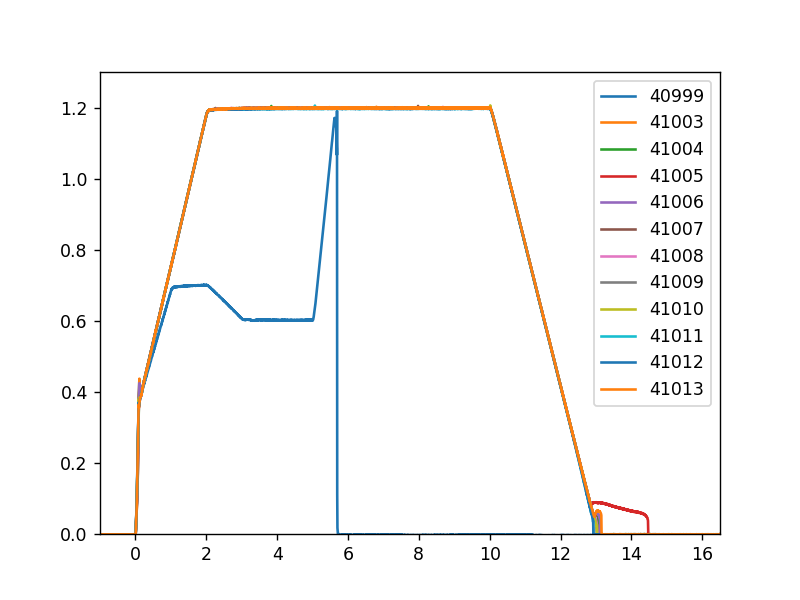

(0, 1.3)

In [98]:
fig,ax=plt.subplots()

for shot in db.keys():
    Ip, t, _ = db[shot]['sipmes']
    ax.plot(t, Ip, label=str(shot))
ax.legend()
ax.set_xlim(-1, 16.5)
ax.set_ylim(0, 1.3)

There is a problem with shot \#40999, which should not be used in the latter analysis. Other shot seems fine.

<IPython.core.display.Javascript object>


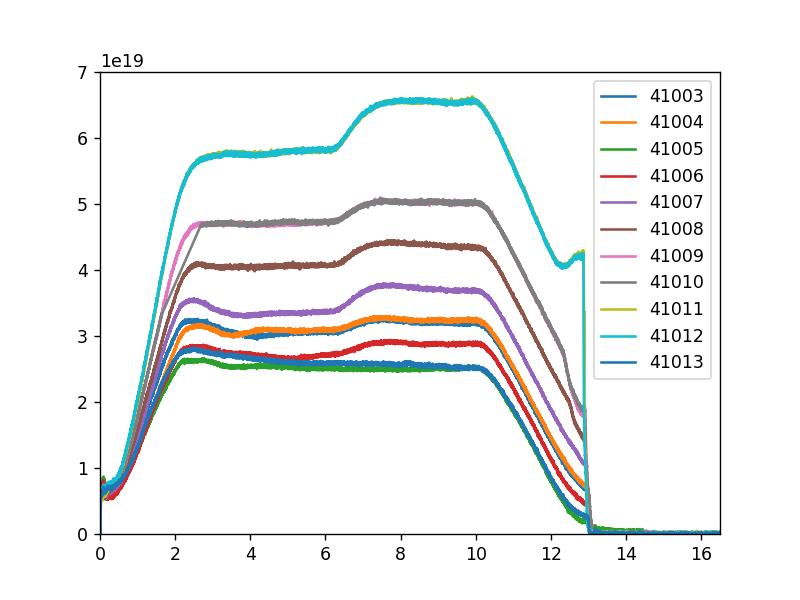

(0, 7e+19)

In [100]:
fig,ax=plt.subplots()

for shot in db.keys():
    if shot == 40999:
        pass
    else:
        ne, t, _, _ = db[shot]['gnl']
        ax.plot(t, ne[:,3] , label=str(shot)) # central chord
ax.legend()
ax.set_xlim(0,16.5)
ax.set_ylim(0,7e19)

# Energy Confinement Time from basics

## Plasma Energy Content

The total stored energy in the plasma is:
$$
W = \int \frac{3}{2} p \, d^3 x
$$
where $p = n k_B T$ is the plasma pressure. Assuming the plasma is quasi-neutral, it has equal densities of positive and negative charges. With few impurities, then $n_i \approx n_e$. Assuming the electron and ion temperatures are equal ($T=T_i=T_e$), then:
$$
p  = 2n_e k_B T_e
$$
Here, $T$ is in eV, in order for the pressure to be expressed in Pascal ($J/m^3$). 

Electron density $n_e$ and temperature $T_e$ depend of the location in the plasma. So one must integrate:
$$
W = 3 k_B \int n_e  T_e \, d^3 x
$$
To perform the integral, we must first define the coordinate system. Let's use a [toroidal coordinate system](http://fusionwiki.ciemat.es/wiki/Toroidal_coordinates) $(r,\phi,\theta)$

![http://fusionwiki.ciemat.es/fusionwiki/images/thumb/1/10/Toroidal_coordinates.png/800px-Toroidal_coordinates.png](attachment:image.png)

where $R=R_0+r\cos\theta$, $Z=r\sin\theta$. $R_0$ is the _major radius_ and $r$ the _minor radius_ ($0\leq r \leq a$)

The elementary volume of the plasma is:
$$
d^3 x \equiv r \, dr \, d\theta \, d\phi 
$$
then,
$$
W = 3k_B (2\pi)^2 R_0 \int_0^a r\, n_e(r)  T_e(r) \, dr
$$

Let's perform the calculus for a single shot and time-frame to test. First, let's import the data.  

In [110]:
# electron density
ne, t_ne, rho_ne, *_ = db[41004]['gne']

# electron temperature
Te, t_Te, *_ = db[41004]['gshte']
R_Te, t_Re, *_ = db[41004]['gshr']

# plasma major and minor radii
R0, t_R0, *_ = db[41004]['srmaj']  
r, t_r, *_ = db[41004]['saeqa']

Let's define a convenient function which is calculating the time-average between two times $t_1$ and $t_2$ : 

In [35]:
# time-average between t1 and t2 (but not radius-average)
def average_over_timeframe(t, y, t1, t2):
    idx = np.flatnonzero((t > t1) & (t < t2))
    mean = y[idx].mean(axis=0) 
    return mean

In [111]:
# Calculate the time-averages valies during the Ip plateau #1
avg_Te = average_over_timeframe(t_Te, Te, 4, 5) # (32,)
avg_ne = average_over_timeframe(t_ne, ne, 4, 5) # (11,)
avg_R0 = average_over_timeframe(t_R0, R0, 4, 5)

r_ne = rho_ne * r # normalized --> absolute radius (9360, 11). 
r_Te = R_Te - avg_R0

avg_r_Te = average_over_timeframe(t_Re, r_Te, 4, 5) # (32,)
avg_r_ne = average_over_timeframe(t_ne, r_ne, 4, 5) # (11,)

# interpolate Te over the ne radius. Fill with 0 if out of the bounds
interp_fun_Te = interp1d(avg_r_Te, avg_Te, fill_value=0, bounds_error=False)
interp_Te = interp_fun_Te(avg_r_ne)

<IPython.core.display.Javascript object>


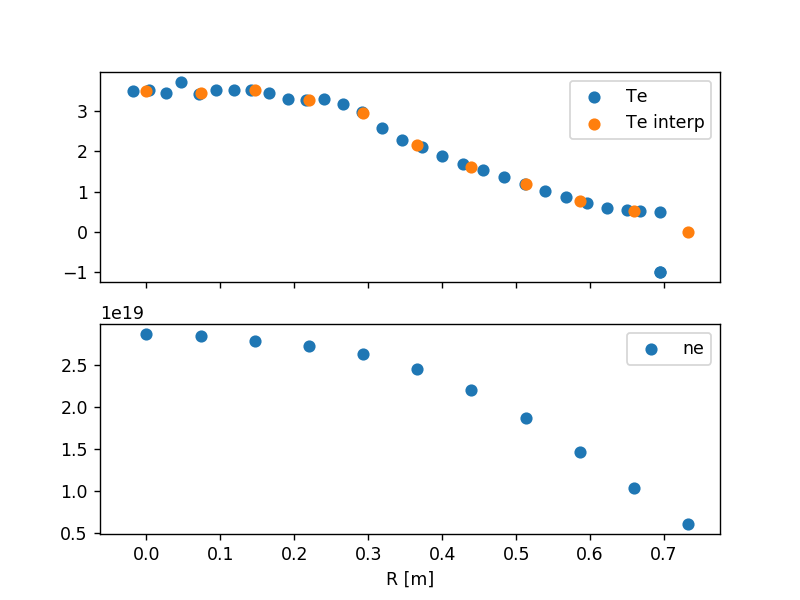

In [112]:
fig,ax=plt.subplots(2,1,sharex=True)
ax[0].scatter(avg_r_Te, avg_Te, label='Te')
ax[0].scatter(avg_r_ne, interp_Te, label='Te interp')
ax[1].scatter(avg_r_ne, avg_ne, label='ne')
ax[1].set_xlabel('R [m]')
[a.legend() for a in ax] 

Let's integrate. Pay attention to the conversion between keV to Kelvin.

In [118]:
3 * (2*pi)**2 * avg_R0 * \
    trapz(y=avg_r_ne * avg_ne * interp_Te * 1e3 * e , x=avg_r_ne)

array([ 398448.83678883])

Now compare with the `SWDIA` signal which does the same:

In [119]:
Wdia, t_Wdia, *_ = db[41004]['swdia'] #in [MJ] --> [J]
average_over_timeframe(t_Wdia, Wdia, 4, 5)*1e6

array([ 235011.76478683])

We see that a factor ~2 between these two... (explanations??)

Now, let's package everything and write a routine to analyse all the pulses and plateau.

In [156]:
# times for plateau
t_plateau1 = (4, 6)
t_plateau2 = (8, 10)

W_means = []
P_means = []
tau_means = []
ne_means = []
Pohm_means = []

# for each shot (except the first one), 
# get the average parameters for each plateau 
for shot in db.keys():
    if shot == 40999:
        pass
    else:
        # electron density
        ne, t_ne, rho_ne, *_ = db[shot]['gne']
        
        # line integrated density
        nl, t_nl, *_ = db[shot]['gnl']
        
        # electron temperature
        Te, t_Te, *_ = db[shot]['gshte']
        R_Te, t_Re, *_ = db[shot]['gshr']
        
        # plasma major and minor radii
        R0, t_R0, _ = db[shot]['srmaj'] 
        r, t_r, _ = db[shot]['saeqa']
        
        # plasma current and loop voltage
        Ip, t_ip, *_ = db[shot]['sipmes']
        #Vl, t_Vl, *_ = db[shot]['']
        Pohm, t_Pohm, *_ = db[shot]['spohm']
        
        # Calculate the time-averages values during the Ip plateaus
        for t_plateau in zip(t_plateau1, t_plateau2):
            # plasma energy content
            avg_Te = average_over_timeframe(t_Te, Te, t_plateau[0], t_plateau[1]) # (32,)
            avg_ne = average_over_timeframe(t_ne, ne, t_plateau[0], t_plateau[1]) # (11,)
            avg_nl = average_over_timeframe(t_nl, nl[:,0] , t_plateau[0], t_plateau[1])
            avg_R0 = average_over_timeframe(t_R0, R0, t_plateau[0], t_plateau[1])
            avg_r  = average_over_timeframe(t_r, r, t_plateau[0], t_plateau[1])
            
            r_ne = rho_ne * r # normalized --> absolute radius (9360, 11). 
            r_Te = R_Te - avg_R0

            avg_r_Te = average_over_timeframe(t_Re, r_Te, t_plateau1[0], t_plateau1[1]) # (32,)
            avg_r_ne = average_over_timeframe(t_ne, r_ne, t_plateau1[0], t_plateau1[1]) # (11,)

            # interpolate Te over the ne radius. Fill with 0 if out of the bounds
            interp_fun_Te = interp1d(avg_r_Te, avg_Te, fill_value=0, bounds_error=False)
            interp_Te = interp_fun_Te(avg_r_ne)

            W = 3 * (2*pi)**2 * avg_R0 * \
                trapz(y=avg_r_ne * avg_ne * interp_Te * 1e3 * e, x=avg_r_ne)
            W_means.append(W)
            
            ne_means.append(avg_nl/avg_r)

            # Ohmic power
            avg_Pohm = 1e6*average_over_timeframe(t_Pohm, Pohm, t_plateau[0], t_plateau[1])
            Pohm_means.append(avg_Pohm)
            
            tau_means.append(W/avg_Pohm)

<IPython.core.display.Javascript object>


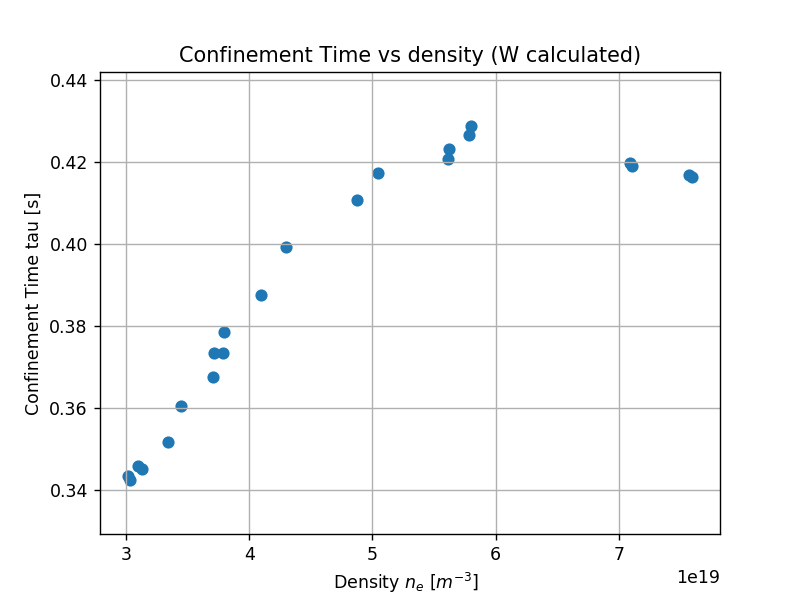

Text(0.5,1,'Confinement Time vs density (W calculated)')

In [157]:
fig, ax = plt.subplots()
ax.scatter(ne_means, tau_means)
ax.set_xlabel('Density $n_e$ [$m^{-3}$]  ')
ax.set_ylabel('Confinement Time tau [s]')
ax.grid(True)
ax.set_title('Confinement Time vs density (W calculated)')

In [44]:
tau_dia, t_tau_dia, _ = tsbase(41004, 'staudia') 
average_over_timeframe(t_tau_dia, tau_dia, 4, 5) # in s

array([ 0.21747221])

In [45]:
P_rad, t_P_rad, _ = tsbase(41004, 'sprad') 
average_over_timeframe(t_P_rad, P_rad, 4, 5) 

array([ 0.4924411])

In [46]:
P_ohm, t_P_ohm, _ = tsbase(41004, 'spohm') 
average_over_timeframe(t_P_ohm, P_ohm, 4, 5) 

array([ 1.08162975])

The usual line-averaged density in $m^{-2}$ is defined by:
$$
\bar{n}_e = \frac{1}{a} \int_0^a n_e \, dr
$$

## Energy Confinement Time and Lawson Criterion

In [158]:
# times for plateau
t_plateau1 = (4, 6)
t_plateau2 = (8, 10)

W_means = []
P_means = []
tau_means_ = []
ne_means = []

# for each shot (except the first one), 
# get the average parameters for each plateau 
for shot in db.keys():
    if shot == 40999:
        pass
    else:
        W, t_W, _ = db[shot]['swdia']
        P, t_P, _ = db[shot]['spohm']
        tau, t_tau, _ = db[shot]['staudia'] 
        # line integrated density
        nl, t_nl, *_ = db[shot]['gnl']
        # plasma minor radius
        r, t_r, _ = db[shot]['saeqa']
        
        for t_plateau in zip(t_plateau1, t_plateau2):
            avg_nl = average_over_timeframe(t_nl, nl[:,0] , t_plateau[0], t_plateau[1])
            avg_r  = average_over_timeframe(t_r, r, t_plateau[0], t_plateau[1])
            avg_W = average_over_timeframe(t_W, W, t_plateau[0], t_plateau[1])
            avg_P = average_over_timeframe(t_P, P, t_plateau[0], t_plateau[1])

            W_means.append(avg_W)
            P_means.append(avg_P)
            tau_means_.append(avg_W/avg_P)
            ne_means.append(avg_nl/avg_r)
            
W_means = np.asarray(W_means)
P_means = np.asarray(P_means)
tau_means_ = np.asarray(tau_means_)
ne_means = np.asarray(ne_means)

<IPython.core.display.Javascript object>


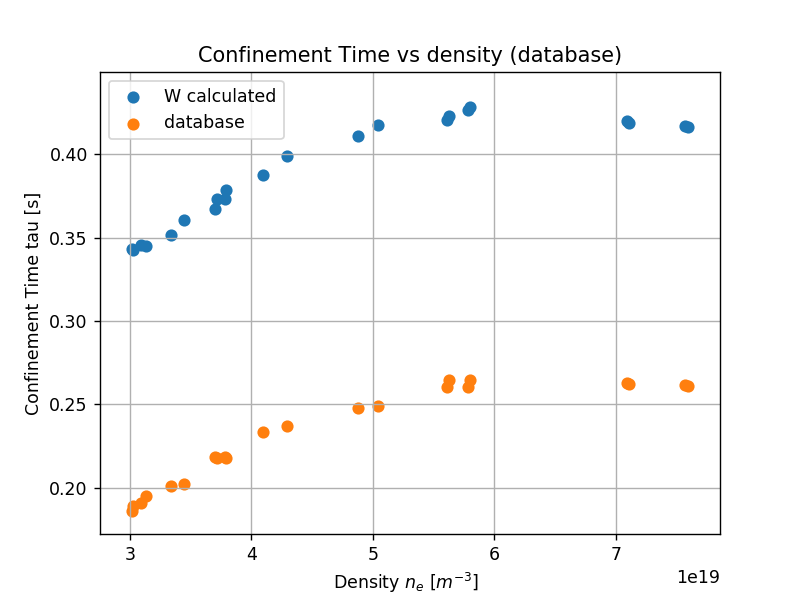

Text(0.5,1,'Confinement Time vs density (database)')

In [162]:
fig,ax = plt.subplots()
ax.scatter(ne_means, tau_means, label='W calculated')
ax.scatter(ne_means, tau_means_, label='database')
ax.legend()
ax.grid(True)
ax.set_xlabel('Density $n_e$ [$m^{-3}$]  ')
ax.set_ylabel('Confinement Time tau [s]')
ax.set_title('Confinement Time vs density (database)')

# Empirical Scaling Law

Goldston (1984) obtained the following L-mode plasma empirical law:
$$
\tau_e = 3.7\times 10^{-5}I_p P^{-0.5} R_0^{1.75} a^{-0.37}
$$

# CSS Syling

In [27]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()